To summarize the case, given dataset has excessive number of zero-valued observations. Problem can be divited into two seperete problems:
1. one that determines whether an event occurs (claim is made)
2. other determines frequency of events when they do occur

Two possible GLM models that can be taken into considerations in this case are:
1. Zero-Inflated Poisson: Assumes that excess zeros come from a separate process, while the remaining data follow a Poisson distribution.
2. Zero-Inflated Negative Binomial (ZINB): Extends ZIP by accounting for overdispersion (greater variance than in the Poisson model).

We already proven in the data exploration notebook that variance of claim frequency is aproximatelly 2 times bigger than its mean, therefore I will use Likelihood Ratio Test to compare these models.


### Import libraries and data load

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.discrete.count_model import ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import chi2
import pickle

In [4]:
df = pd.read_csv("feature_selected_data.csv")
df

,VehPower,VehAge,DrivAge,Area,VehBrand,VehGas,Region,ClaimFrequency,VehPowerDriverAge,TransformBonusMalus,TransformDensity,isClaim
0,5.0,0.0,55.0,D,B12,Regular,R82,1.000000,0.090909,3.912023,7.104144,1
1,5.0,0.0,55.0,D,B12,Regular,R82,1.298701,0.090909,3.912023,7.104144,1
2,6.0,2.0,52.0,B,B12,Diesel,R22,1.333333,0.115385,3.912023,3.988984,1
3,7.0,0.0,46.0,B,B12,Diesel,R72,1.190476,0.152174,3.912023,4.330733,1
4,6.0,2.0,38.0,E,B12,Regular,R31,1.923077,0.157895,3.912023,8.007367,1
...,...,...,...,...,...,...,...,...,...,...,...,...
677997,4.0,0.0,54.0,E,B12,Regular,R93,0.000000,0.074074,3.912023,8.106816,0
677998,4.0,0.0,41.0,E,B12,Regular,R11,0.000000,0.097561,4.553877,9.195227,0
677999,6.0,2.0,45.0,D,B12,Diesel,R82,0.000000,0.133333,3.912023,7.187657,0
678000,4.0,0.0,60.0,B,B12,Regular,R26,0.000000,0.066667,3.912023,4.553877,0


### Preprocess data for model training

In [ ]:
X = df.drop(columns=['ClaimFrequency', "isClaim"], axis=1)
y = df['ClaimFrequency']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

In [ ]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop="first"), cat_features) # droping first categorical variable to avoid colinearity (Area_A, Region_R11, VehBrand_B1, VehGas_Diesel)
])

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

X_train_transformed = pd.DataFrame(X_train_transformed.toarray(), columns=preprocessor.get_feature_names_out())
X_test_transformed = pd.DataFrame(X_test_transformed.toarray(), columns=preprocessor.get_feature_names_out())

In [12]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True) 

In [24]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_transformed.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_transformed.values, i) for i in range(X_train_transformed.shape[1])]

print(vif_data[vif_data["VIF"] > 10])

                  Feature        VIF
3  num__VehPowerDriverAge  10.301801


In [25]:
X_train_transformed.drop(columns=["num__VehPowerDriverAge"], axis=1, inplace=True)
X_test_transformed.drop(columns=["num__VehPowerDriverAge"], axis=1, inplace=True)

### Likelihood Ratio Test

In [28]:
# Fit Zero-Inflated Poisson (ZIP) Model
zip_model = ZeroInflatedPoisson(y_train, sm.add_constant(X_train_transformed)).fit()
print(zip_model.summary())

# Fit Zero-Inflated Negative Binomial (ZINB) Model
zinb_model = ZeroInflatedNegativeBinomialP(y_train, sm.add_constant(X_train_transformed)).fit()
print(zinb_model.summary())

d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.248864
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:          ClaimFrequency   No. Observations:               542401
Model:             ZeroInflatedPoisson   Df Residuals:                   542358
Method:                            MLE   Df Model:                           42
Date:                 Wed, 12 Mar 2025   Pseudo R-squ.:                0.005102
Time:                         22:52:06   Log-Likelihood:            -1.3498e+05
converged:                       False   LL-Null:                   -1.3568e+05
Covariance Type:             nonrobust   LLR p-value:                6.489e-263
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
inflate_const                2.2794      0.006    352.884      0.000       2.267       2.292
const                       -0.7221      0.050    -14.471      0.000      -0.820 

d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.248728
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                    ClaimFrequency   No. Observations:               542401
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                   542358
Method:                                      MLE   Df Model:                           42
Date:                           Wed, 12 Mar 2025   Pseudo R-squ.:                0.004105
Time:                                   23:07:52   Log-Likelihood:            -1.3491e+05
converged:                                 False   LL-Null:                   -1.3547e+05
Covariance Type:                       nonrobust   LLR p-value:                1.027e-205
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
inflate_const               -2.8946        nan        nan        nan         nan         nan
c

In [29]:
# Likelihood Ratio Test to compare models
lr_stat = 2 * (zinb_model.llf - zip_model.llf)
df_diff = zinb_model.df_model - zip_model.df_model
p_value = chi2.sf(lr_stat, df_diff)
print(f"Likelihood Ratio Test Statistic: {lr_stat}, p-value: {p_value}")

best_model = zinb_model if p_value < 0.05 else zip_model
print("Selected Model:", "ZINB" if p_value < 0.05 else "ZIP")

with open('glm_model_all.pkl','wb') as f:
    pickle.dump(best_model,f)

Likelihood Ratio Test Statistic: 147.2390123611549, p-value: nan
Selected Model: ZIP


### Feature selection and model training

In [30]:
# Backward Stepwise Feature Selection
def backward_stepwise_selection(model, X, y, threshold=0.05):
    model_class = model.model.__class__
    while True:
        p_values = model.pvalues.drop('const')  # Exclude intercept
        worst_feature = p_values.idxmax()
        if p_values.max() > threshold:
            X = X.drop(columns=[worst_feature])
            model = model_class(y, sm.add_constant(X)).fit() 
        else:
            break
    return model, X

In [31]:
with open('glm_model_all.pkl', 'rb') as f:
    best_model = pickle.load(f)

final_model, final_X_train = backward_stepwise_selection(best_model, X_train_transformed, y_train)
print(final_model.summary())

with open('glm_model.pkl','wb') as f:
    pickle.dump(final_model,f)

d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.248864
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.248864
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.248864
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.248864
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.248865
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.248865
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.248866
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.248867
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.248873
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.248878
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.248882
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.248884
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.248889
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.248888
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.248891
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.248896
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.248898
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.248900
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.248903
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.248907
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\scipy\optimize\_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.248918
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


d:\Projects\PricingRecrutationProject\FrequencyOfClaimsPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:          ClaimFrequency   No. Observations:               542401
Model:             ZeroInflatedPoisson   Df Residuals:                   542379
Method:                            MLE   Df Model:                           21
Date:                 Wed, 12 Mar 2025   Pseudo R-squ.:                0.004887
Time:                         23:28:43   Log-Likelihood:            -1.3501e+05
converged:                       False   LL-Null:                   -1.3568e+05
Covariance Type:             nonrobust   LLR p-value:                6.100e-268
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
inflate_const                2.2782      0.006    353.733      0.000       2.266       2.291
const                       -0.7184      0.023    -31.148      0.000      -0.764 

### Model evaluation

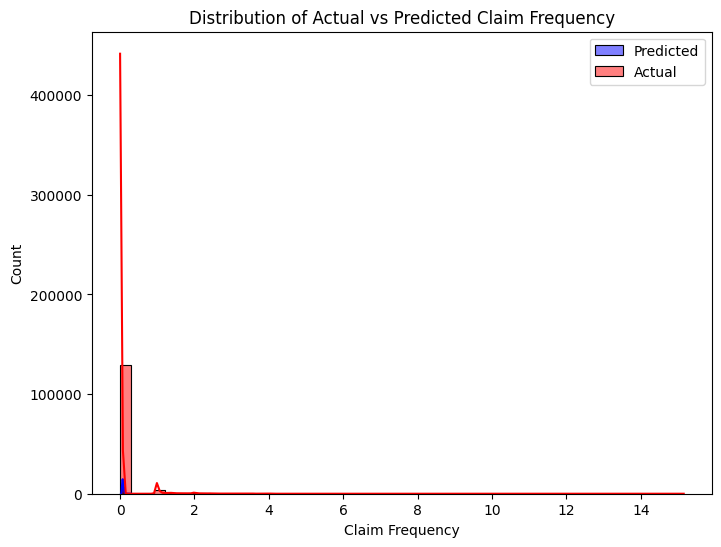

In [32]:
with open('glm_model.pkl', 'rb') as f:
    final_model = pickle.load(f)

final_X_test = X_test_transformed[final_X_train.columns]
y_pred = final_model.predict(sm.add_constant(final_X_test))

plt.figure(figsize=(8, 6))
sns.histplot(y_pred, bins=50, kde=True, color='blue', label='Predicted')
sns.histplot(y_test, bins=50, kde=True, color='red', label='Actual')
plt.xlabel("Claim Frequency")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Actual vs Predicted Claim Frequency")
plt.show()